# Assignment 3 - Autoregressive Language Modeling with Transformers

In [1]:
%pip install torch==2.4.1 datasets==3.1.0

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import math
import inspect
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import functional as F

from datasets import load_dataset

# Data

In [3]:
import torch
from datasets import load_dataset

class MovieDataset(torch.utils.data.Dataset):
    def __init__(self, block_size=256):
        # Load dataset
        ds = load_dataset("Pablinho/movies-dataset")
        data = ds['train'].to_pandas()

        # Convert to pandas and create string format
        text_data = ""
        for _, row in data.iterrows():
            text_data += f"{row['Title']}: {row['Overview']}\n"

        # Create character mappings
        chars = sorted(list(set(text_data)))
        self.string_to_int = {ch:i for i,ch in enumerate(chars)}
        self.int_to_string = {i:ch for i,ch in enumerate(chars)}

        # Encode text to integers
        encoded_data = [self.string_to_int[c] for c in text_data]

        # Convert to tensor
        self.data = torch.tensor(encoded_data, dtype=torch.long)
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        # grab a chunk of (block_size + 1) characters from the data
        chunk = self.data[idx:idx + self.block_size + 1]
        x = chunk[:-1]  # all but last
        y = chunk[1:]   # all but first
        return x, y

    def decode(self, ids):
        return ''.join([self.int_to_string[i.item()] for i in ids])

# Model

In [4]:
@dataclass
class GPTConfig:
    vocab_size: int # Number of unique tokens in the vocabulary
    block_size: int = 256 # Sequence length
    n_block: int = 6 # Number of blocks in the transformer
    n_head: int = 6 # Number of attention heads
    n_embd: int = 384 # Embedding dimensionality
    dropout: float = 0.2 # Dropout rate
    bias: bool = True # If True, we add a bias to the LayerNorm and Linear layers.

In [5]:
class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0, f"Embedding dimension {config.n_embd} must be divisible by number of heads {config.n_head}"

        self.n_head = config.n_head # Number of attention heads
        self.n_embd = config.n_embd # Embedding dimensionality
        self.dropout = config.dropout # Dropout rate

        # Maps embedding into Q, K, V. We'll use one layer to generate these matrices for all heads at once.
        # This is more efficient since everything can be computes as one single matrix multiplication.
        self.qkv_map = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)

        # After performing attention for each head individually, we project the results back to the embedding space.
        self.proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)

        # Regularization
        self.final_dropout = nn.Dropout(self.dropout)


    def forward(self, x):
        B, T, C = x.shape # batch size, sequence length, embedding dimensionality (n_embd)
        d_k = C // self.n_head # Dimension of the query and key (within a head)

        # TODO: Implement Causal Self Attention
        # Hint: The output of the qkv_map is a tensor of shape (B, T, 3*C).
        # We need to split this tensor into Q, K, and V tensors of shape (B, T, C) each. Split it in this precise order for the test function (see below) to work.
        # Afterwards, reshape and transpose them to the correct shape (see assert statements),
        # such that we have (smaller) Q, K, and V matrices for each head.
        mappings = self.qkv_map(x)
        Q, K , V = mappings.split(self.n_embd, dim=2)

        Q = Q.view(B, T, self.n_head, d_k).transpose(1,2)
        K = K.view(B, T, self.n_head, d_k).transpose(1,2)
        V = V.view(B, T, self.n_head, d_k).transpose(1,2)

        for M in [Q, K, V]:
            assert M.shape == (B, self.n_head, T, d_k), f"Expected shape (B, self.n_head, T, d_k), but got {M.shape}"

        # TODO: Performs causally masked, multi-head scaled dot-product self-attention
        # Compute the attention weights and aggregated values.
        # Hint: Broadcasted matrix multiplication can be implemented using the @ operator.
        # Hint: `torch.tril` may help you with masking the attention scores. Set values to -inf before the softmax to get a softmax output of 0.

        attention_score = (Q @ K.transpose(-2, -1)) * (1.0/ math.sqrt(d_k))
        mask = torch.tril(torch.ones(T,T,device=x.device))
        attention_score = attention_score.masked_fill(mask==0, float("-inf"))
        attention_score = F.softmax(attention_score, dim=-1)
        
        aggregated_vals = attention_score @ V # this is the output of each attention head, which is a weighted sum of the values in V
        assert aggregated_vals.shape == (B, self.n_head, T, d_k), f"Expected aggregated_vals shape (B, self.n_head, T, d_k), but got {aggregated_vals.shape}"

        # Combine all head outputs into the last dimension
        out = aggregated_vals.transpose(1, 2).reshape(B, T, C)
        out = self.proj(out) # This combines the outputs of all heads
        out = self.final_dropout(out) # This is the final dropout layer

        return out

You can test your implementation of the `CausalSelfAttention` class by running the following code:

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = GPTConfig(vocab_size=10, block_size=8, n_block=6, n_head=6, n_embd=12, dropout=0.0, bias=True)

torch.manual_seed(1337)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)

x = torch.randn(2, 8, 12).to(device)
attention = CausalSelfAttention(config).to(device)
att_out = attention(x)

# Read expected output from file
att_out_expected = torch.load('CausalSelfAttention_out.pt', map_location=device)


assert torch.allclose(att_out, att_out_expected,  atol=1e-6)

/tmp/ipykernel_373562/73728907.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  att_out_expected = torch.load('CausalSelfAttention_out.pt', map_location=device)


In [7]:
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        # TODO: Implement the MLP
        # It should consist of a linear layer, a GELU activation function, and a final linear layer.
        # After the final linear layer, apply dropout with dropout rate config.dropout.
        # The linear layers should have a bias term if config.bias is True, and no bias term otherwise.

        #activation func
        self.activation = nn.GELU()

        # The first linear layer should map from config.n_embd to 4 * config.n_embd.
        self.first = nn.Linear(config.n_embd, 4*config.n_embd, bias=config.bias)

        # The second linear layer should map from 4 * config.n_embd back to config.n_embd.
        self.second = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)

        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        # TODO: Implement the forward pass of the MLP
        x = self.first(x)
        x = self.activation(x)
        x = self.second(x)
        x = self.dropout(x)
        return x


In [8]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layernorm_1 = nn.LayerNorm(config.n_embd, bias=config.bias)
        self.attention = CausalSelfAttention(config)
        self.layernorm_2 = nn.LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attention(self.layernorm_1(x))
        x = x + self.mlp(self.layernorm_2(x))
        return x

In [9]:
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            embed_token = nn.Embedding(config.vocab_size, config.n_embd),
            embed_position = nn.Embedding(config.block_size, config.n_embd),
            dropout = nn.Dropout(config.dropout),
            blocks = nn.ModuleList([Block(config) for _ in range(config.n_block)]),
            layernorm = nn.LayerNorm(config.n_embd, bias=config.bias),
        ))

        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # We use the same weights for the token embeddings and the final linear layer, since they in principal do the same thing.
        # This can help speed up training.
        # For more information, you can have a look at https://doi.org/10.48550/arXiv.1608.05859
        self.transformer.embed_token.weight = self.head.weight

        # Initialize all linear layers using our custom init function
        self.apply(self._init_params)

        # report number of parameters
        print(f"Number of parameters in GPT: {self.get_num_params()/1e6:.2f}M")


    def _init_params(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)


    def get_num_params(self):
        unique_params = {id(p) : p.numel() for p in self.parameters()}
        return sum(unique_params.values())


    def forward(self, idx):
        device = idx.device
        b, t = idx.shape
        assert t <= self.config.block_size, f"Cannot process sequence of length {t}, block size is only {self.config.block_size}"
        position_idxs = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # TODO: Implement the forward pass of the GPT model
        # Embed the tokens and positions using the embedding layers self.transformer.embed_token and self.transformer.embed_position.
        token_emb = self.transformer.embed_token(idx)
        position_emb = self.transformer.embed_position(position_idxs)

        # Add the token embeddings and position embeddings together and pass the result through the dropout layer.
        x = token_emb + position_emb
        x = self.transformer.dropout(x)
        # Pass the result through all the transformer blocks.
        for block in self.transformer.blocks:
            x = block(x)
        # Apply layer normalization and finally obtain the logits by project the result to
        x = self.transformer.layernorm(x)
        # the vocabulary space using the head layer.
        
        logits = self.head(x)

        return logits


    def get_optimizer(self, weight_decay, learning_rate, betas, device):
        param_dict = {pn: p for pn, p in self.named_parameters() if p.requires_grad}

        # We will decay all parameters that are 2D or higher dimensional.
        # This includes all weight matrices and embeddings.
        decay_params = [p for n, p in param_dict.items() if len(p.shape) >= 2]
        # We will not decay biases and layernorm parameters (which are 1D).
        nodecay_params = [p for n, p in param_dict.items() if len(p.shape) < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]

        fused = (device == 'cuda')
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, fused=fused)

        return optimizer


    @torch.no_grad()
    def sample(self, idx, max_new_tokens, temperature=1.0):
        # idx is of shape (batch_size, sequence_length)

        for _ in range(max_new_tokens):
            # If the sequence context is growing too long we must crop it at block_size
            idx_input = idx if idx.shape[1] <= self.config.block_size else idx[:, -self.config.block_size:]
            # TODO: Push idx_input through the model to get the logits for the next token in the sequence
            # Hint: The logits that are returned by the model are of shape (batch_size, sequence_length, vocab_size).
            logits = self(idx_input)
            
            # To predict the next token, we only need the logits for the last position in the sequence.
            logits_last = logits[:, -1, :]  # (B, vocab_size)
            if temperature <= 0:
                raise ValueError("temperature has to be > 0")
            
            # Next, divide the logits by the desired temperature and apply the softmax function to convert them to probabilities.
            probs = F.softmax(logits_last / temperature, dim=-1)
            
            # Finally, sample the next token from this probability distribution.
            next_token = torch.multinomial(probs, num_samples=1)
            assert next_token.shape == (idx.shape[0], 1), f"Expected next_token shape (batch_size, 1), but got {next_token.shape}"
            
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, next_token), dim=1)

        return idx

# Training

In [10]:
@torch.no_grad()
def estimate_train_val_loss(model, train_loader, val_loader, val_iters, device):
    model.eval()
    losses = {}
    for split, loader in [('train', train_loader), ('val', val_loader)]:
        total_loss = 0
        for i, (X, Y) in enumerate(loader):
            if i >= val_iters:
                break
            X, Y = X.to(device), Y.to(device)
            logits = model(X)
            loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), Y.view(-1), ignore_index=-1)
            total_loss += loss.item()
        losses[split] = total_loss / val_iters
    model.train()

    return losses

In [11]:
# Set seeds for reproducibility
torch.manual_seed(1337)

block_size = 128
batch_size = 128

# Create datasets and dataloaders
data = MovieDataset(block_size)

# split into train and validation sets
train_len = int(len(data) * 0.8)
val_len = len(data) - train_len
train_dataset, val_dataset = torch.utils.data.random_split(data, [train_len, val_len])

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

# TODO: You may fetch a batch from the dataloader here to answer Task a)
x, y = next(iter(train_loader))

print(f"x shape: {x.shape}, y shape: {y.shape}") 
print(f"x Bsp: {x[0]}")
print(f"\nDecoded X: {data.decode(x[0])},\n Y: {data.decode(y[0])}")


README.md: 0.00B [00:00, ?B/s]

9000plus.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/9837 [00:00<?, ? examples/s]

x shape: torch.Size([128, 128]), y shape: torch.Size([128, 128])
x Bsp: tensor([66,  2, 84, 69, 76,  2, 79, 66, 83, 66, 62, 73, 80,  2, 69, 70, 74, 80,
        66, 73, 67,  2, 81, 76,  2, 63, 66,  2, 62,  2, 19, 18, 26, 15, 86, 66,
        62, 79, 15, 76, 73, 65,  2, 83, 62, 74, 77, 70, 79, 66, 16,  2, 35, 66,
        80, 77, 70, 81, 66,  2, 36, 65, 84, 62, 79, 65,  9, 80,  2, 79, 66, 77,
        66, 62, 81, 66, 65,  2, 64, 62, 82, 81, 70, 76, 75, 80, 14,  2, 33, 66,
        73, 73, 62,  2, 64, 62, 75,  9, 81,  2, 80, 81, 62, 86,  2, 62, 84, 62,
        86,  2, 67, 79, 76, 74,  2, 69, 70, 74, 14,  2, 62,  2, 67, 62, 81, 62,
        73,  2])

Decoded X: e who reveals himself to be a 108-year-old vampire. Despite Edward's repeated cautions, Bella can't stay away from him, a fatal ,
 Y:  who reveals himself to be a 108-year-old vampire. Despite Edward's repeated cautions, Bella can't stay away from him, a fatal m


In [31]:
import time

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

out_dir = 'MovieGPT'
checkpoint_path = os.path.join(out_dir, 'checkpoint.pt')
os.makedirs(out_dir, exist_ok=True)  # Create output directory

# TODO: You may change the training configuration as desired, especially in Task h)
# You may also add loops for automated hyperparameter search and
# timestamps to track training time.

# Eval/Logging
val_interval = 500 # Number of iterations between evaluations
val_iters = 20 # Number of iterations for evaluation
log_interval = 10 # Number of iterations between logging

# Optimizer settings
learning_rate = 1e-3 # Larger networks typically require a learning rate that is smaller than this
max_iters = 5_000 # Number of iterations to train for
weight_decay = 1e-1 # Weight decay for regularization (on the weights/embeddings)
beta1, beta2 = 0.9, 0.99 # Beta1, Beta2 for AdamW optimizer
grad_clip = 1.0 # Clip gradients at this value, or disable if == 0.0

# Compile model
compile_model = False # Compile the model for faster execution. Note: no debug breakpoints in compiled models!

# Model config
vocab_size = len(data.string_to_int)
config = GPTConfig(
    block_size=block_size,
    vocab_size=vocab_size,
    n_block=4,
    n_head=4,
    n_embd=128,
    dropout=0.0,
    bias=False
) # This is a relatively small model

model = GPT(config).to(device)

if compile_model:
    print("Compiling the model...")
    model = torch.compile(model) # Needs PyTorch >= 2.0
    print("Done compiling")

def count_parameters(m: torch.nn.Module) -> int:
    return sum(p.numel() for p in m.parameters())

def train_model(
    model,
    train_loader,
    val_loader,
    *,
    device,
    max_iters,
    learning_rate,
    weight_decay=1e-1,
    beta1=0.9,
    beta2=0.99,
    grad_clip=1.0,
    log_interval=10,
    val_interval=500,
    val_iters=20,
):

    # Initialize optimizer
    optimizer = model.get_optimizer(weight_decay, learning_rate, (beta1, beta2), device)

    # Training loop
    iter_num = 0
    best_val_loss = float('inf')
    eval_steps = []
    train_losses = []
    val_losses = []

    t0 = time.time()
    for _ in range(max_iters):
        for X, Y in train_loader:
            # Get batch and move to device
            X, Y = X.to(device), Y.to(device)

            # Forward pass
            logits = model(X)

            loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), Y.view(-1), ignore_index=-1)

            # Backward pass
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            if grad_clip != 0.0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

            # Logging
            if iter_num % log_interval == 0:
                print(f"iter {iter_num}: loss {loss.item():.4f}")

            # Evaluation
            if iter_num % val_interval == 0:
                losses = estimate_train_val_loss(model, train_loader, val_loader, val_iters, device)
                print(f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

                eval_steps.append(iter_num)
                train_losses.append(losses['train'])
                val_losses.append(losses['val'])

                # Save best model
                if losses['val'] < best_val_loss:
                    best_val_loss = losses['val']
                    if iter_num > 0:
                        print(f"Saving checkpoint to {out_dir}")
                        model_to_save = model._orig_mod if compile_model else model
                        torch.save({
                            'model': model_to_save.state_dict(),
                            'model_args': config,
                        }, checkpoint_path)

            iter_num += 1
            if iter_num >= max_iters:
                break

        if iter_num >= max_iters:
            break
        
    elapsed = time.time() - t0
    return eval_steps, train_losses, val_losses, elapsed


eval_steps, train_losses, val_losses, elapsed = train_model(
        model, 
        train_loader, 
        val_loader,
        device=device,
        max_iters=max_iters,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        beta1=beta1,
        beta2=beta2,
        grad_clip=grad_clip,
        val_interval=val_interval,
        val_iters=val_iters,
    )

print(f"Done baseline: params={count_parameters(model):,} time={elapsed:.1f}s")

cuda
Number of parameters in GPT: 0.83M
iter 0: loss 5.1492
step 0: train loss 4.6113, val loss 4.6103
iter 10: loss 3.4762
iter 20: loss 2.9979
iter 30: loss 2.7717
iter 40: loss 2.6876
iter 50: loss 2.6302
iter 60: loss 2.5752
iter 70: loss 2.5782
iter 80: loss 2.5404
iter 90: loss 2.5411
iter 100: loss 2.5199
iter 110: loss 2.5203
iter 120: loss 2.4970
iter 130: loss 2.4638
iter 140: loss 2.4754
iter 150: loss 2.4595
iter 160: loss 2.4566
iter 170: loss 2.4422
iter 180: loss 2.4179
iter 190: loss 2.3917
iter 200: loss 2.3938
iter 210: loss 2.3575
iter 220: loss 2.3201
iter 230: loss 2.2885
iter 240: loss 2.2960
iter 250: loss 2.2890
iter 260: loss 2.2701
iter 270: loss 2.2154
iter 280: loss 2.2310
iter 290: loss 2.2225
iter 300: loss 2.1565
iter 310: loss 2.1863
iter 320: loss 2.1403
iter 330: loss 2.1114
iter 340: loss 2.0933
iter 350: loss 2.0886
iter 360: loss 2.0571
iter 370: loss 2.0475
iter 380: loss 2.0546
iter 390: loss 2.0206
iter 400: loss 1.9809
iter 410: loss 2.0017
iter

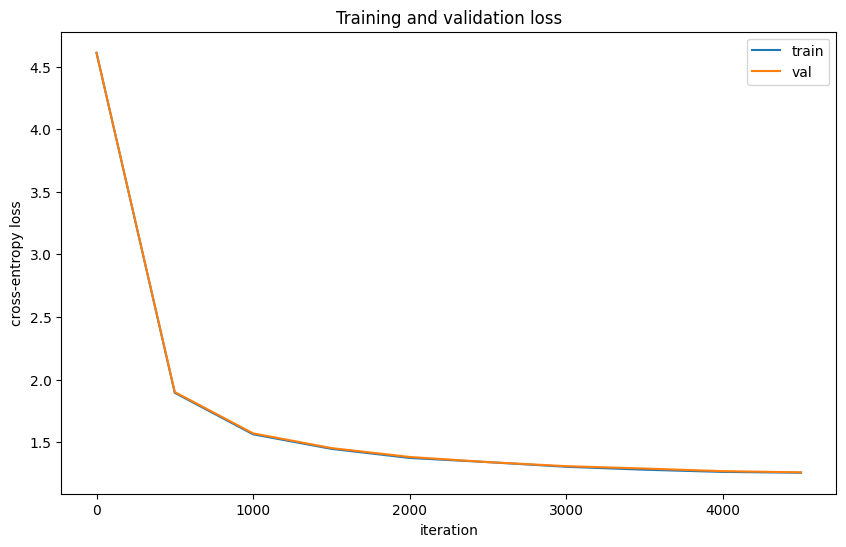

In [ ]:
# TODO: Plot the train- and validation loss.
# To speed up training, they are only computed every val_interval iterations. Adapt this value if you like.
# Since dropout is enabled during training, the training loss is computed again during the validation step without dropout.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(eval_steps, train_losses, label="train")
plt.plot(eval_steps, val_losses, label="val")
plt.xlabel("iteration")
plt.ylabel("cross-entropy loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# Sample from the model

In [33]:
num_samples = 5  # Number of samples to draw
max_new_tokens = 500  # Number of tokens generated in each sample.
temperatures = [1.5, 1.0, 0.8, 0.5, 0.1, 0.0001]  # TODO: Use different temperature values and qualitatively report on the results



# Load the model
checkpoint = torch.load(checkpoint_path, map_location=device)
config = checkpoint['model_args']
model = GPT(config)
model.load_state_dict(checkpoint['model'])
model.eval()
model.to(device)

# Create dataset to get encoder/decoder
dataset = MovieDataset(block_size=config.block_size)
encode = lambda s: [dataset.string_to_int[c] for c in s]
decode = dataset.decode

# TODO: You may change the loop for automated testing
start_prompts = [
    "\n",
    "The movie is about",
    "In a distant future"
]

# Generate samples
for temperature in temperatures:
    print('-'*40)
    print(f"Temperature = {temperature}")
    print("-"*40)
    with torch.no_grad():
        for prompt in start_prompts:
            # Set seed for reproducibility
            seed = 345
            torch.manual_seed(seed)
            if torch.cuda.is_available():
                torch.cuda.manual_seed(seed)
            print("-"*40)
            print(f"start prompt: {repr(prompt)}")
            print("-"*40)
            prompt_ids = encode(prompt)
            x = torch.tensor(prompt_ids, dtype=torch.long, device=device)[None, ...]
            for k in range(num_samples):
                y = model.sample(x, max_new_tokens, temperature=temperature)
                print(f"[sample {k+1}]")
                print(decode(y[0]))
                print()

/tmp/ipykernel_373562/3199856869.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Number of parameters in GPT: 0.83M
----------------------------------------
Temperature = 1.5
----------------------------------------
----------------------------------------
start prompt: '\n'
----------------------------------------
[sample 1]

Jessmaizer-Rash: When LZ (32996) If Futebbaqurra_pero's Gandalf (MIC]-tha Qão cga Qicke1.My)²œlos)'s quipes often God's engearious dolllerging anvaiet.
K.: RPRP.“ wi world in 192w SazaMdn. Their Gail kids' best:  Beirlead adventure. Full-arring knidnap his want davisatin, 11vadrun, Mgogan in is missed-down Edi,"
Class In(GOD]² of thou‘s 963, Show Rajined and Redjini, Jolin ever ovad on Ja-ScW after!. With may go so sjust ’D Yóls’’e' humans active story on exist initiates adventures and wes, obl

[sample 2]

HPhineois: a welegahtic man. They'llbosht fights for a hapmirer course. These ying dreamiCop. CookslidhoiZere's employes i
Day to HoygwÁis: Thempedthhy ill behind at far Chic-Oh swimmoileed bying each 35 solics age the boots’. édeffers  l


----------------------------------------
Training archA | block=128 n_block=6 n_head=4 n_embd=128
----------------------------------------
Number of parameters in GPT: 1.23M
iter 0: loss 5.1810
step 0: train loss 4.7499, val loss 4.7505
iter 10: loss 3.7398
iter 20: loss 3.1493
iter 30: loss 2.8852
iter 40: loss 2.7679
iter 50: loss 2.6912
iter 60: loss 2.6318
iter 70: loss 2.6205
iter 80: loss 2.5767
iter 90: loss 2.5511
iter 100: loss 2.5421
iter 110: loss 2.5405
iter 120: loss 2.5447
iter 130: loss 2.5316
iter 140: loss 2.5183
iter 150: loss 2.5078
iter 160: loss 2.4884
iter 170: loss 2.4737
iter 180: loss 2.4739
iter 190: loss 2.4830
iter 200: loss 2.4606
iter 210: loss 2.4558
iter 220: loss 2.4221
iter 230: loss 2.4196
iter 240: loss 2.3969
iter 250: loss 2.3966
iter 260: loss 2.3878
iter 270: loss 2.3617
iter 280: loss 2.3499
iter 290: loss 2.3278
iter 300: loss 2.2931
iter 310: loss 2.2982
iter 320: loss 2.2966
iter 330: loss 2.2641
iter 340: loss 2.2358
iter 350: loss 2.2262
i

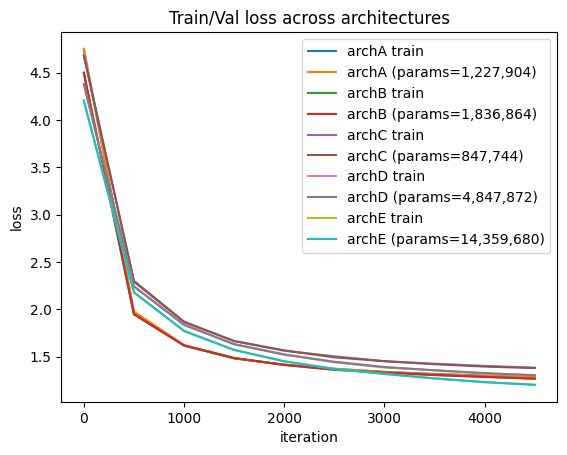

In [23]:
import matplotlib.pyplot as plt

def count_parameters(m: torch.nn.Module) -> int:
    return sum(p.numel() for p in m.parameters())

def train_gpt_one(
    *,
    block_size: int,
    batch_size: int,
    n_block: int,
    n_head: int,
    n_embd: int,
    dropout: float,
    learning_rate: float,
    max_iters: int,
    val_interval: int = 500,
    val_iters: int = 20,
    weight_decay: float = 1e-1,
    beta1: float = 0.9,
    beta2: float = 0.99,
    grad_clip: float = 1.0,
    device: str = "cpu",
):
    # Data
    data_h = MovieDataset(block_size)

    train_len = int(len(data_h) * 0.8)
    val_len = len(data_h) - train_len
    train_ds, val_ds = torch.utils.data.random_split(data_h, [train_len, val_len])

    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader   = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    vocab_size_h = len(data_h.string_to_int)
    config_h = GPTConfig(
        block_size=block_size,
        vocab_size=vocab_size_h,
        n_block=n_block,
        n_head=n_head,
        n_embd=n_embd,
        dropout=dropout,
        bias=True,
    )
    model_h = GPT(config_h).to(device)

    eval_steps, train_losses, val_losses, elapsed = train_model(
        model_h, train_loader, val_loader,
        device=device,
        max_iters=max_iters,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        beta1=beta1,
        beta2=beta2,
        grad_clip=grad_clip,
        val_interval=val_interval,
        val_iters=val_iters,
    )

    return {
        "config": config_h,
        "params": count_parameters(model_h),
        "eval_steps": eval_steps,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "seconds": elapsed,
        "model_state": model_h.state_dict(),
    }

# Define 5+ architectures (feel free to edit hyperparameters)
architectures = [
    dict(name="archA",    block_size=128, batch_size=128, n_block=6, n_head=4, n_embd=128, dropout=0.1, lr=8e-4, max_iters=5000),
    dict(name="archB",    block_size=128, batch_size=96,  n_block=4, n_head=6, n_embd=192, dropout=0.1, lr=6e-4, max_iters=5000),
    dict(name="archC",    block_size=256, batch_size=64,  n_block=4, n_head=4, n_embd=128, dropout=0.1, lr=6e-4, max_iters=5000),
    dict(name="archD",    block_size=256, batch_size=48,  n_block=6, n_head=4, n_embd=256, dropout=0.2, lr=3e-4, max_iters=5000),
    dict(name="archE",    block_size=256, batch_size=128,  n_block=8, n_head=8, n_embd=384, dropout=0.2, lr=1e-4, max_iters=5000)
]

results = {}

for arch in architectures:
    print("\n" + "-"*40)
    print(f"Training {arch['name']} | block={arch['block_size']} n_block={arch['n_block']} n_head={arch['n_head']} n_embd={arch['n_embd']}")
    print("-"*40)
    res = train_gpt_one(
        block_size=arch["block_size"],
        batch_size=arch["batch_size"],
        n_block=arch["n_block"],
        n_head=arch["n_head"],
        n_embd=arch["n_embd"],
        dropout=arch["dropout"],
        learning_rate=arch["lr"],
        max_iters=arch["max_iters"],
        device=device,
    )
    results[arch["name"]] = res
    print(f"Done {arch['name']}: params={res['params']:,} time={res['seconds']:.1f}s")

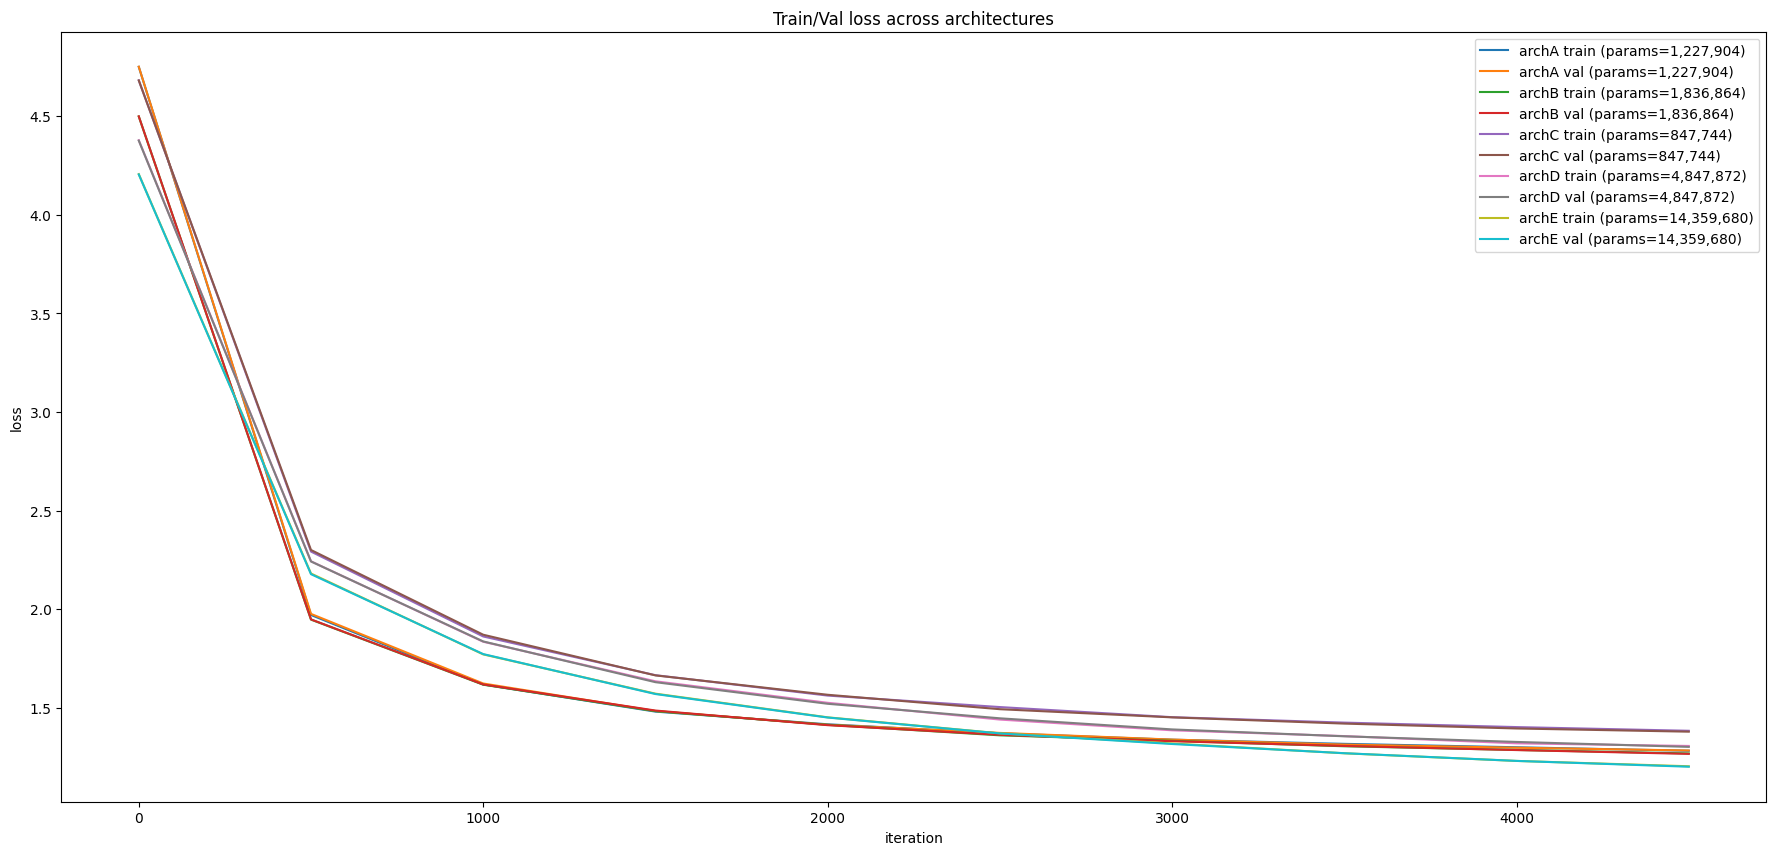

In [25]:
# Plot validation curves for all models
plt.figure(figsize=(22, 10))
for name, res in results.items():
    plt.plot(res["eval_steps"], res["train_losses"], label=f"{name} train (params={res['params']:,})")
    plt.plot(res["eval_steps"], res["val_losses"], label=f"{name} val (params={res['params']:,})")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.title("Train/Val loss across architectures")
plt.legend()
plt.show()

In [29]:
import torch

@torch.no_grad()
def generate_samples_from_results(results, start_prompts, temperature=0.8, max_new_tokens=300, num_samples=5):
    print("\n" + "-"*40)
    print(f"Sampling comparison at fixed τ={temperature}")
    print("-"*40)
    
    for name, res in results.items():
        config = res["config"]
        model = GPT(config)
        model.load_state_dict(res["model_state"])
        model.eval()
        model.to(device)
        
        dataset = MovieDataset(block_size=config.block_size)
        encode = lambda s: [dataset.string_to_int[c] for c in s]
        decode = dataset.decode

        print("\n" + "-"*40)
        print(f"{name} | params={res['params']:,} | block_size={config.block_size} | τ={temperature}")
        print("-"*40)
        
        for prompt in start_prompts:
            seed = 345
            torch.manual_seed(seed)
            if torch.cuda.is_available():
                torch.cuda.manual_seed(seed)
            print("-"*40)
            print(f"start prompt: {repr(prompt)}")
            print("-"*40)
            prompt_ids = encode(prompt)
            x = torch.tensor(prompt_ids, dtype=torch.long, device=device)[None, ...]
            for k in range(num_samples):
                y = model.sample(x, max_new_tokens, temperature=temperature)
                print(f"[sample {k+1}]")
                print(decode(y[0]))
                print()


start_prompts_h = [
    "\n",
    "The movie is about",
    "In a distant future",
]

generate_samples_from_results(
    results,
    start_prompts=start_prompts_h,
    temperature=0.8,
    max_new_tokens=300,
    num_samples=5,
)



----------------------------------------
Sampling comparison at fixed τ=0.8
----------------------------------------
Number of parameters in GPT: 1.23M

----------------------------------------
archA | params=1,227,904 | block_size=128 | τ=0.8
----------------------------------------
----------------------------------------
start prompt: '\n'
----------------------------------------
[sample 1]

Once Night Rail: When a young submari technique superhero and female trapped ingeniously attracts the reserve of Mary's entire throne. In the courage, a guy joins with the air heart, and but he has been attended by incredible family, the and his skiller parents develop named My Malay Toy of the mass

[sample 2]

La Indered Nebrace: In this inventual King of Poleyman: The summer single in the door worse, the adventures of a communistic life. In the hunt of the suspect of the surrounding secret plan, while more while is accused to confront the mission for the Best has imposed with a family.
Nerve